# Problem 1

In [10]:
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import math
import sklearn.metrics as metrics

In [11]:
# Load MNIST
f = gzip.open('data/mnist.pkl.gz') 
mnist = pickle.load(f, encoding='latin1')

In [12]:
mnist_train_features = mnist[0][0] #(50000,784)
mnist_train_labels = mnist[0][1]   #(50000,1)

mnist_valid_features = mnist[1][0] #(10000,784)
mnist_valid_labels = mnist[1][1]   #(50000,1)

mnist_test_features = mnist[2][0]  #(10000,784)
mnist_test_labels = mnist[2][1]    #(50000,1)

In [13]:
# Reduce the dataset size for testing, if needed (ex: X_train = mnist_train_features[0:10000])
X_train = mnist_train_features[0:3000]
y_train = mnist_train_labels[0:3000]

X_valid = mnist_valid_features[0:300]
y_valid = mnist_valid_labels[0:300]

X_test = mnist_test_features[0:300]
y_test = mnist_test_labels[0:300]

## Building the Model

In [34]:
class NN(object):
    
    def __init__(self,hidden_dims=(1024,2048),weight_mode=None, mode="ReLU"):
        self.b1 = np.zeros((hidden_dims[0]))
        self.b2 = np.zeros((hidden_dims[1]))
        self.b3 = np.zeros((10))
        self.learning_rate = 0.0005
        self.initialize_weights(hidden_dims,weight_mode)
        self.act_mode = mode

    def initialize_weights(self,hidden_dims,weight_mode):
        W1_dim = (784, hidden_dims[0])
        W2_dim = (hidden_dims[0], hidden_dims[1])
        W3_dim = (hidden_dims[1], 10)
        
        if weight_mode == "zero":
            self.W1 = np.zeros(W1_dim)
            self.W2 = np.zeros(W2_dim)
            self.W3 = np.zeros(W3_dim)
            
        elif weight_mode == "normal":
            np.random.seed(23)
            self.W1 = np.random.standard_normal(W1_dim)
            self.W2 = np.random.standard_normal(W2_dim)
            self.W3 = np.random.standard_normal(W3_dim)
            
        elif weight_mode == "glorot":
            np.random.seed(23)
            
            d1 = math.sqrt(6.0 / (W1_dim[0] + W1_dim[1]))
            d2 = math.sqrt(6.0 / (W2_dim[0] + W2_dim[1]))
            d3 = math.sqrt(6.0 / (W3_dim[0] + W3_dim[1]))
            
            self.W1 = np.random.uniform(-d1, d1, W1_dim)
            self.W2 = np.random.uniform(-d2, d2, W2_dim)
            self.W3 = np.random.uniform(-d3, d3, W3_dim)
        
        else:
            raise Exception("Unsupported weight_mode value")

    def forward(self,data):
        cache = {}
        
        cache["h0"] = np.copy(data)
        cache["a1"] = np.dot(cache["h0"], self.W1) + self.b1
        cache["h1"] = self.activation(cache["a1"], self.act_mode)
        cache["a2"] = np.dot(cache["h1"], self.W2) + self.b2
        cache["h2"] = self.activation(cache["a2"], self.act_mode)
        cache["a3"] = np.dot(cache["h2"], self.W3) + self.b3
        cache["h3"] = self.softmax(cache["a3"])
        
        return cache

    def activation(self,data, mode="ReLU"):
        if(mode == "ReLU"):
            return self.ReLU(data)
        elif(mode == "sigmoid"):
            return self.sigmoid(data)
        else:
            raise Exception("Not an activation function")
    
    def activation_derivative(self,data, mode="ReLU"): # RELU derivative
        if(mode == "ReLU"):
            return self.ReLU_derivative(data)
        elif(mode == "sigmoid"):
            return self.sigmoid_derivative(data)
        else:
            raise Exception("Not an activation function")
    
    def sigmoid(self, data):
        return 1/(1+np.exp(-data))
    
    def sigmoid_derivative(self,data):
        return self.sigmoid(data)*(1-self.sigmoid(data))
    
    def ReLU(self,data): # RELU
        return np.where(data > 0, data, 0.0)
    
    def ReLU_derivative(self,data):
        return np.where(data > 0, 1.0, 0.0)

    def loss(self, data, labels, eps = 1e-15): # Cross Entropy loss
        cache = self.forward(data)
        preds = np.clip(cache["h3"], eps, 1 - eps)
        preds = preds / np.sum(preds, axis=1)[:, np.newaxis]
        one_hot_truth = np.eye(10)[labels]
        log_loss = -np.diag(np.matmul(one_hot_truth,np.log(preds).T))
        return  np.average(log_loss)
#         return metrics.log_loss(labels, preds)

    def softmax(self,data): # Numerically stable softmax
        result = np.exp(data - np.max(data, axis=1, keepdims=True))
        result = result / np.sum(result, axis=1, keepdims=True)
        return result

    def backward(self,cache,labels):
        grads = {}

        grads["a3"] = cache["h3"] - np.eye(10)[labels]
        grads["W3"] = np.dot(cache["h2"].T, grads["a3"])
        grads["b3"] = np.sum(grads["a3"], axis=0)
        
        grads["h2"] = np.dot(grads["a3"], self.W3.T)
        grads["a2"] = grads["h2"] * self.activation_derivative(cache["a2"], self.act_mode)
        grads["W2"] = np.dot(cache["h1"].T, grads["a2"])
        grads["b2"] = np.sum(grads["a2"], axis=0)
        
        grads["h1"] = np.dot(grads["a2"], self.W2.T)
        grads["a1"] = grads["h1"] * self.activation_derivative(cache["a1"], self.act_mode)
        grads["W1"] = np.dot(cache["h0"].T, grads["a1"])
        grads["b1"] = np.sum(grads["a1"], axis=0)
        
        return grads

    def update(self,grads):
        self.b3 -= (self.learning_rate * grads["b3"])
        self.W3 -= (self.learning_rate * grads["W3"])
        self.b2 -= (self.learning_rate * grads["b2"])
        self.W2 -= (self.learning_rate * grads["W2"])
        self.b1 -= (self.learning_rate * grads["b1"])
        self.W1 -= (self.learning_rate * grads["W1"])

    def train(self,data,labels, mini_batch_size = 0, epochs = 10, learning_rate = 0.0005, lr_decay = 1, lr_decay_intervals = 0):
        self.learning_rate = learning_rate
        train_info = {}
        train_info["average_losses"] = []
        train_info["accuracy"]=[]
        decay_flag = True
        
        # print("Epoch\tAccuracy\tAverage Loss")
        data_mini = []
        label_mini = []
        
        if (mini_batch_size==0):
            mini_batch_size = np.shape(data)[0]
            
        if (lr_decay==1):
            decay_flag = False
            
        if (lr_decay>1):
            raise ValueError("lr_decay has to be equal or under to 1")
            
        if (decay_flag==True):
            if lr_decay_intervals!=0:
                lr_decay_intervals = lr_decay_intervals
            else:
                lr_decay_intervals = [0.2,0.6]
        
        for epoch in range(epochs): # TODO: implement mini-batch gradient descent
            for i in range(0, np.shape(data)[0], mini_batch_size):
                
                #Mini-batch training
                data_mini = data[i:i + mini_batch_size]
                labels_mini = labels[i:i + mini_batch_size]
                
                #forward and backward propagation
                cache = self.forward(data_mini)
                grads = self.backward(cache,labels_mini)
                self.update(grads)
                
                #Measuring loss and accuracy
                predictions = np.argmax(cache["h3"], axis=1)
                accuracy = np.mean(predictions == labels_mini)
                average_loss = self.loss(data_mini, labels_mini)

            if(decay_flag):
                if (epoch in np.dot(lr_decay_intervals,epochs)):
                    learning_rate = learning_rate * lr_decay
                    print(learning_rate)
            
            train_info["average_losses"].append(average_loss)
            train_info["accuracy"].append(accuracy)    
            print(epoch + 1, "\t", "{0:.4f}".format(accuracy), "\t", "{0:.4f}".format(average_loss))
        
        return train_info

    def test(self, data, labels):
        cache = self.forward(data)
        predictions = cache["h3"].argmax(1).astype(int)
        accuracy = np.mean(predictions == labels)
        return accuracy


## Initialization

zero
1 	 0.1300 	 2.3025
2 	 0.1300 	 2.3028
0.0005
3 	 0.1300 	 2.3031
4 	 0.1300 	 2.3035
5 	 0.1300 	 2.3038
6 	 0.1300 	 2.3041
0.00025
7 	 0.1300 	 2.3043
8 	 0.1300 	 2.3045
9 	 0.1300 	 2.3046
10 	 0.1300 	 2.3047

normal
1 	 0.1000 	 2.3170
2 	 0.1300 	 2.3102
0.0005
3 	 0.1300 	 2.3065
4 	 0.1300 	 2.3047
5 	 0.1300 	 2.3039
6 	 0.1300 	 2.3037
0.00025
7 	 0.1300 	 2.3037
8 	 0.1300 	 2.3039
9 	 0.1300 	 2.3041
10 	 0.1300 	 2.3043

glorot
1 	 0.8400 	 0.6415
2 	 0.8800 	 0.4075
0.0005
3 	 0.8900 	 0.3190
4 	 0.9100 	 0.2624
5 	 0.9200 	 0.2200
6 	 0.9300 	 0.1873
0.00025
7 	 0.9400 	 0.1615
8 	 0.9400 	 0.1401
9 	 0.9600 	 0.1233
10 	 0.9700 	 0.1094



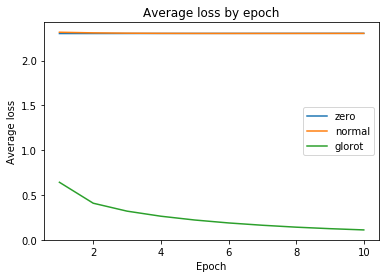

In [35]:
for weight_mode in ["zero", "normal", "glorot"]:
#for weight_mode in ["glorot"]:
    print(weight_mode)
    nn = NN(hidden_dims=(800,300),weight_mode=weight_mode, mode="ReLU")
    train_info = nn.train(X_train, y_train, epochs = 10, mini_batch_size=100, learning_rate = 0.001, lr_decay = 0.5)
    plt.plot(np.arange(1,11,1), train_info["average_losses"], label=weight_mode)
    print()

plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()

## Hyperparameter Search

In [37]:
# Grid Search

lr = [0.01, 0.008, 0.012]
hiddens_dims = [(625,625)]
mini_batch = [64]
epoch = (20,30,40)


# Mode = ReLU
best = 0
best_params = {}

for lr_ in lr:
    for hd in hiddens_dims:
        for mb in mini_batch:
            for epoch_ in epoch:
                #print("Lr : {}, hd : {}, mb : {}".format(lr_, hd, mb))
                model = NN(hidden_dims = hd, weight_mode = "glorot", mode = "ReLU")
                train_log = model.train(X_train, y_train, epochs = epoch_,
                                        mini_batch_size=mb, learning_rate = lr_, lr_decay = 0.8,
                                        lr_decay_intervals = [0.2, 0.5, 0.8])
                acc = model.test(X_valid, y_valid)
                if(acc>best):
                    best = acc
                    best_params["lr"] = lr_
                    best_params["hd"] = hd
                    best_params["mb"] = mb
                    best_params["epoch"]=epoch_
                              
print(best, best_params)

# # Mode = sigmoid
# best_s = 0
# best_params_s = {}

# for lr_ in lr:
#     for hd in hiddens_dims:
#         for mb in mini_batch:
#             for epoch_ in epoch:
#                 #print("Lr : {}, hd : {}, mb : {}".format(lr_, hd, mb))
#                 model = NN(hidden_dims = hd, weight_mode = "glorot", mode = "sigmoid")
#                 train_log = model.train(X_train, y_train, epochs = epoch_, mini_batch_size=mb, learning_rate = lr_)
#                 acc = model.test(X_valid, y_valid)
#                 if(acc>best_s):
#                     best_s = acc
#                     best_params_s["lr"] = lr_
#                     best_params_s["hd"] = hd
#                     best_params_s["mb"] = mb
#                     best_params_s["epoch"]=epoch_
                              
# print(best_s, best_params_s)

1 	 0.9107 	 0.2318
2 	 0.9286 	 0.1235
3 	 0.9464 	 0.0633
4 	 0.9643 	 0.0475
0.008
5 	 0.9643 	 0.0316
6 	 0.9821 	 0.0168
7 	 0.9821 	 0.0183
8 	 1.0000 	 0.0057
9 	 1.0000 	 0.0029
10 	 1.0000 	 0.0023
0.0064
11 	 1.0000 	 0.0020
12 	 1.0000 	 0.0017
13 	 1.0000 	 0.0015
14 	 1.0000 	 0.0013
15 	 1.0000 	 0.0012
16 	 1.0000 	 0.0011
0.00512
17 	 1.0000 	 0.0010
18 	 1.0000 	 0.0009
19 	 1.0000 	 0.0008
20 	 1.0000 	 0.0008
1 	 0.9107 	 0.2318
2 	 0.9286 	 0.1235
3 	 0.9464 	 0.0633
4 	 0.9643 	 0.0475
5 	 0.9643 	 0.0316
6 	 0.9821 	 0.0168
0.008
7 	 0.9821 	 0.0183
8 	 1.0000 	 0.0057
9 	 1.0000 	 0.0029
10 	 1.0000 	 0.0023
11 	 1.0000 	 0.0020
12 	 1.0000 	 0.0017
13 	 1.0000 	 0.0015
14 	 1.0000 	 0.0013
15 	 1.0000 	 0.0012
0.0064
16 	 1.0000 	 0.0011
17 	 1.0000 	 0.0010
18 	 1.0000 	 0.0009
19 	 1.0000 	 0.0008
20 	 1.0000 	 0.0008
21 	 1.0000 	 0.0007
22 	 1.0000 	 0.0007
23 	 1.0000 	 0.0006
24 	 1.0000 	 0.0006
0.00512
25 	 1.0000 	 0.0006
26 	 1.0000 	 0.0005
27 	 1.000

## Validating Gradients Using Finite Difference

In [ ]:
# Code taken from Marc-André's homework#3 of IFT6390 class.

def finite_diff_gradient_check(self,X, Y, verbose = False):
"""
-----
Parameters: 
    X : inputs of dimension d for 1 example o , todo, do for mini batch
    onehot_Y : encoded target associated to X 
    Y : index of class
"""
X = X.reshape((1, X.shape[0]))
self.fprop(X)
onehot_Y = to_categorical(Y, num_classes=self.m).reshape((1, self.m))
self.bprop(X,onehot_Y)

loss_fprop = self.loss

eta = 10**(-5)

finite_grad_W1 = self.check_onebyone(X, Y, eta, loss_fprop, self.W1, (self.dh, self.d))
ratio_W1 = np.nanmean(finite_grad_W1/self.grad_W1)

finite_grad_W2 = self.check_onebyone(X, Y, eta, loss_fprop, self.W2, (self.m, self.dh))
ratio_W2 = np.nanmean(finite_grad_W2/self.grad_W2)

finite_grad_b1 = self.check_onebyone(X, Y, eta, loss_fprop, self.b1, (1, self.dh))
ratio_b1 = np.nanmean(finite_grad_b1/self.grad_b1.reshape((1, self.dh)))

finite_grad_b2 = self.check_onebyone(X, Y, eta, loss_fprop, self.b2, (1, self.m))
ratio_b2 = np.nanmean(finite_grad_b2/self.grad_b2.reshape((1, self.m)))

check = True
ratios = [ratio_W1 ,ratio_W2, ratio_b1, ratio_b2]

for ratio in ratios:
    check = check and ratio < 1.01 and ratio > 0.99

if (verbose):
    print("Backprop gradient W1")
    print(np.nan_to_num(self.grad_W1))
    print("Finite gradient W1")
    print(np.nan_to_num(finite_grad_W1))
    print("     -------------------------------")
    print("Backprop gradient b1")
    print(np.nan_to_num(self.grad_b1))
    print("Finite gradient b1")
    print(np.nan_to_num(finite_grad_b1))
    print("     -------------------------------")
    print("Backprop gradient W2")
    print(np.nan_to_num(self.grad_W2))
    print("Finite gradient W2")
    print(np.nan_to_num(finite_grad_W2))
    print("     -------------------------------")
    print("Backprop gradient b2")
    print(np.nan_to_num(self.grad_b2))
    print("Finite gradient b2")
    print(np.nan_to_num(finite_grad_b2))
    print("     -------------------------------")
    print(f" ratio W1 : {ratio_W1}  \n ratio b1 : {ratio_b1} \
          \n ratio W2 : {ratio_W2} \n ratio b2 : {ratio_b2}")

return check